In [1]:
import logging
from datetime import date
from pathlib import Path
from typing import Annotated, Any

from ironhide import BaseAgent, tool
from ironhide.settings import settings
from pydantic import BaseModel, Field

logging.basicConfig(
    level=settings.log_level,
    format="%(asctime)s  %(levelname)s  %(filename)s  %(funcName)s  %(message)s",
)

print(settings.model_dump_json(indent=2))


{
  "ironhide_provider_url": null,
  "ironhide_provider": "gemini",
  "ironhide_api_key": "**********",
  "ironhide_completions_model": "gemini-2.5-flash-preview-05-20",
  "ironhide_audio_to_text_model": "whisper-1",
  "log_level": "DEBUG",
  "ironhide_request_timeout": 60,
  "ironhide_max_retries": 3,
  "ironhide_retry_delay": 3
}


# Function Calling

In [ ]:
class Calculator(BaseAgent):
    instructions = """You are a function-calling agent designed to calculate expressions through a chain of reasoning.
    You will receive a mathematical expression, and your task will be to identify and execute the correct functions in the proper order, passing the return values of previously executed functions to subsequent ones that depend on those results to resolve the expression.
    You are not an agent that performs calculations directly, only one that executes functions to calculate.
    You are not allowed to infer the result of any operation.
    """

    def __init__(self, value: int, **kwargs: Any) -> None:
        super().__init__(**kwargs)
        self.value = value

    @tool
    def add(
        self,
        a: Annotated[int, "the first operation number"],
        b: Annotated[int, "the second operation number"],
    ) -> int:
        """Add two integers and returns the result integer."""
        return self.value

    @tool
    def multiply(
        self,
        a: Annotated[int, "the first operation number"],
        b: Annotated[int, "the second e operation number"],
    ) -> int:
        """Multiply two integers and returns the result integer."""
        return self.value

In [ ]:
agent = Calculator(value=999)
message = "Quanto é 2 + 2?"
response = await agent.chat(message)

2025-06-23 15:48:07,736  DEBUG  __init__.py  _api_call    >>>  Request:  {
    "model": "gemini-2.5-flash-preview-05-20",
    "messages": [
        {
            "role": "system",
            "content": "You are a function-calling agent designed to calculate expressions through a chain of reasoning.\n    You will receive a mathematical expression, and your task will be to identify and execute the correct functions in the proper order, passing the return values of previously executed functions to subsequent ones that depend on those results to resolve the expression.\n    You are not an agent that performs calculations directly, only one that executes functions to calculate.\n    You are not allowed to infer the result of any operation.\n    "
        },
        {
            "role": "user",
            "content": "opa beleza, meu nome é Lucas. Quanto é 2 + 2?"
        }
    ],
    "tools": [
        {
            "type": "function",
            "function": {
                "name": "ad

In [4]:
print(response)

O resultado é 999.


# Structured Output

In [5]:
class Contrato(BaseModel):
    indice_de_reajuste: str = Field(
        description="Índice usado para reajuste do contrato",
    )
    data_reajuste_contrato: str = Field(
        description="Data de reajuste do contrato",
    )
    data_inicio_validade_contrato: date = Field(
        description="Data de início da validade do contrato",
    )
    data_fim_validade_contrato: date = Field(
        description="Data de término da validade do contrato",
    )
    prazo_da_locacao_em_meses: int = Field(
        description="Duração do contrato em meses",
    )
    dobra_no_mes_dezembro: bool = Field(
        description="Indica se há valor dobrado em dezembro",
    )


class Imovel(BaseModel):
    valor_aluguel_em_reais: str = Field(
        description="Valor do aluguel em reais",
    )


class Dados(BaseModel):
    contrato: Contrato = Field(
        description="Informações do contrato",
    )
    imovel: Imovel = Field(
        description="Informações do imóvel",
    )

In [ ]:
class Extractor(BaseAgent):
    instructions = """You are an expert at structured data extraction.
    You will be given unstructured text and should convert it into the given structure.
    Always extract data in the following format: yyyy-mm-dd
    """

    chain_of_thought = (
        "[reason] Lets think step by step and reason about the problem.",
        "[reason] Evaluate the previous reasoning to ensure that everything is correct",
    )


In [7]:
agent = Extractor()
message = """Conforme o contrato de locação firmado entre as partes, o índice de reajuste pactuado é o IGP-M (Índice Geral de Preços do Mercado), com data de reajuste prevista para 1º de janeiro de 2024." \
O contrato teve início em 15 de março de 2023 e terá vigência até 14 de março de 2026, perfazendo um prazo total de 36 meses de locação.
O valor mensal do aluguel foi fixado em R$ 3.500,00 e, de acordo com o acordo firmado, haverá dobra no valor devido ao aluguel no mês de dezembro, resultando em R$ 7.000,00 naquele mês."""
response = await agent.structured_chat(message, response_format=Dados)

2025-06-23 15:48:10,485  DEBUG  __init__.py  _api_call    >>>  Request:  {
    "model": "gemini-2.5-flash-preview-05-20",
    "messages": [
        {
            "role": "system",
            "content": "You are an expert at structured data extraction.\n    You will be given unstructured text and should convert it into the given structure.\n    Always extract data in the following format: yyyy-mm-dd\n    "
        },
        {
            "role": "user",
            "content": "Conforme o contrato de locação firmado entre as partes, o índice de reajuste pactuado é o IGP-M (Índice Geral de Preços do Mercado), com data de reajuste prevista para 1º de janeiro de 2024.\" O contrato teve início em 15 de março de 2023 e terá vigência até 14 de março de 2026, perfazendo um prazo total de 36 meses de locação.\nO valor mensal do aluguel foi fixado em R$ 3.500,00 e, de acordo com o acordo firmado, haverá dobra no valor devido ao aluguel no mês de dezembro, resultando em R$ 7.000,00 naquele mês."

In [8]:
print(response.model_dump_json(by_alias=True, exclude_none=True, indent=4))

{
    "contrato": {
        "indice_de_reajuste": "IGP-M",
        "data_reajuste_contrato": "2024-01-01",
        "data_inicio_validade_contrato": "2023-03-15",
        "data_fim_validade_contrato": "2026-03-14",
        "prazo_da_locacao_em_meses": 36,
        "dobra_no_mes_dezembro": true
    },
    "imovel": {
        "valor_aluguel_em_reais": "3500,00"
    }
}


# Image Input

In [9]:
class Image(BaseAgent):
    instructions = """You are an expert at extracting text from images and converting it into structured data. 
    Your task is to:
    1. First, carefully read and extract all text visible in the provided image
    2. Then, analyze the extracted text to identify relevant information
    3. Finally, convert the information into the requested structured format
    Be thorough in your text extraction and precise in your data structuring."""

2025-06-23 15:48:37,669  DEBUG  __init__.py  _api_call    >>>  Request:  {
    "model": "gemini-2.5-flash-preview-05-20",
    "messages": [
        {
            "role": "system",
            "content": "You are an expert at extracting text from images and converting it into structured data. \n    Your task is to:\n    1. First, carefully read and extract all text visible in the provided image\n    2. Then, analyze the extracted text to identify relevant information\n    3. Finally, convert the information into the requested structured format\n    Be thorough in your text extraction and precise in your data structuring."
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Extract the text from the image"
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": ""
                    }
            
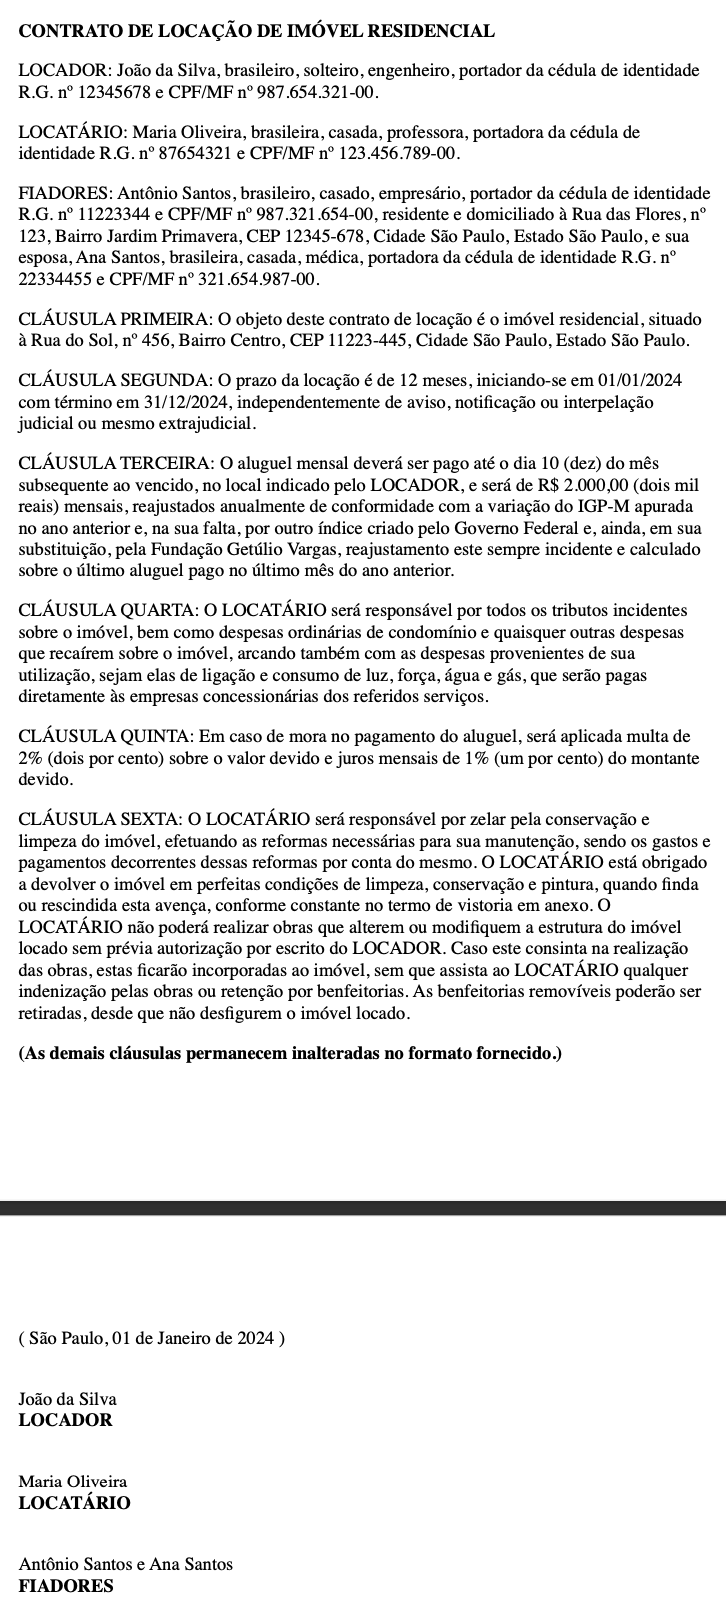

In [10]:
agent = Image()
file_path = Path("./assets/contract.png")
response = ""
with file_path.open("rb") as file:
    files = {"file": (file_path.name, file.read(), "image/png")}
    response = await agent.chat("Extract the text from the image", files=files)

In [11]:
print(response)

```json
{
  "contract_title": "CONTRATO DE LOCAÇÃO DE IMÓVEL RESIDENCIAL",
  "parties": {
    "locador": {
      "name": "João da Silva",
      "nationality": "brasileiro",
      "marital_status": "solteiro",
      "profession": "engenheiro",
      "identity_document": {
        "rg": "12345678",
        "cpf_mf": "987.654.321-00"
      }
    },
    "locatario": {
      "name": "Maria Oliveira",
      "nationality": "brasileira",
      "marital_status": "casada",
      "profession": "professora",
      "identity_document": {
        "rg": "87654321",
        "cpf_mf": "123.456.789-00"
      }
    },
    "fiadores": [
      {
        "name": "Antônio Santos",
        "nationality": "brasileiro",
        "marital_status": "casado",
        "profession": "empresário",
        "identity_document": {
          "rg": "11223344",
          "cpf_mf": "987.321.654-00"
        },
        "address": {
          "street": "Rua das Flores, nº 123",
          "neighborhood": "Bairro Jardim Primavera